In [308]:
from datetime import datetime, timedelta
from tinkoff.invest import CandleInterval, Client
from tinkoff.invest.schemas import CandleSource
import pandas as pd
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta

import yfinance as yf
from dotenv import load_dotenv
import os

load_dotenv()

True

In [309]:
TOKEN = os.getenv("TOKEN")
TROY = 31.1034768
end_date = datetime.now() - timedelta(days=1)
start_date = end_date - relativedelta(years=2)

In [310]:
data_gold_rub, data_usd_rub = [], []

with Client(TOKEN) as client:
    # get the USD rate
    for candle in client.get_all_candles(
        instrument_id="FUTUSDRUBF00",
        from_=start_date,
        to=end_date,
        interval=CandleInterval.CANDLE_INTERVAL_DAY,
        candle_source_type=CandleSource.CANDLE_SOURCE_UNSPECIFIED,
    ):
        data_usd_rub.append({
            'Date': candle.time.date(),
            'Close': candle.close.units + candle.close.nano / 1e9,
        })

    # get the gold rate
    for candle in client.get_all_candles(
        instrument_id="BBG000VJ5YR4",
        from_=start_date,
        to=end_date,
        interval=CandleInterval.CANDLE_INTERVAL_DAY,
        candle_source_type=CandleSource.CANDLE_SOURCE_UNSPECIFIED,
    ):
        data_gold_rub.append({
            'Date': candle.time.date(),
            'Close': candle.close.units + candle.close.nano / 1e9,
        })

df_gold_rub = pd.DataFrame(data_gold_rub)
df_usd_rub = pd.DataFrame(data_usd_rub)

In [311]:
# get the global gold rate
gold_global = yf.download(
    'GC=F',
    start=start_date,
    end=end_date,
    progress=False,
    multi_level_index=False,
)
gold_global = gold_global.reset_index()
gold_global["Date"] = gold_global['Date'].dt.date

/tmp/ipykernel_69232/1652240789.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  gold_global = yf.download(


In [312]:
# prepare columns
gold_global = gold_global.rename(columns={'Close': 'GOLD'})
df_usd_rub = df_usd_rub.rename(columns={'Close': 'USD'})
df_gold_rub = df_gold_rub.rename(columns={'Close': 'T_per_gram'})

# merge
merged_df = pd.merge(gold_global, df_usd_rub, on="Date", how='inner')
merged_df['Yahoo_per_gram'] = ((merged_df['GOLD'] * merged_df['USD']) / TROY).round(2)
merged_df = pd.merge(merged_df, df_gold_rub, on="Date", how='inner')

# calculate difference between global and local gold rate
merged_df['diff_percent'] = ((merged_df['Yahoo_per_gram'] - merged_df['T_per_gram']) / merged_df['T_per_gram'] * 100).round(2)

merged_df.head()


,Date,GOLD,High,Low,Open,Volume,USD,Yahoo_per_gram,T_per_gram,diff_percent
0,2023-10-06,1830.199951,1831.800049,1809.400024,1819.000000,390,100.20,5896.00,5839.26,0.97
1,2023-10-09,1849.500000,1861.500000,1842.500000,1842.500000,232,98.64,5865.41,5855.95,0.16
2,2023-10-10,1861.000000,1861.400024,1852.800049,1857.000000,236,100.39,6006.59,5953.69,0.89
3,2023-10-11,1872.800049,1874.599976,1869.099976,1869.500000,65,97.08,5845.37,5927.98,-1.39
4,2023-10-12,1869.300049,1881.199951,1867.000000,1874.699951,46,97.35,5850.68,5775.00,1.31


In [313]:
# set index
merged_df = merged_df.set_index('Date')[['Yahoo_per_gram', 'T_per_gram', 'diff_percent']].copy()
merged_df.index = pd.to_datetime(merged_df.index)

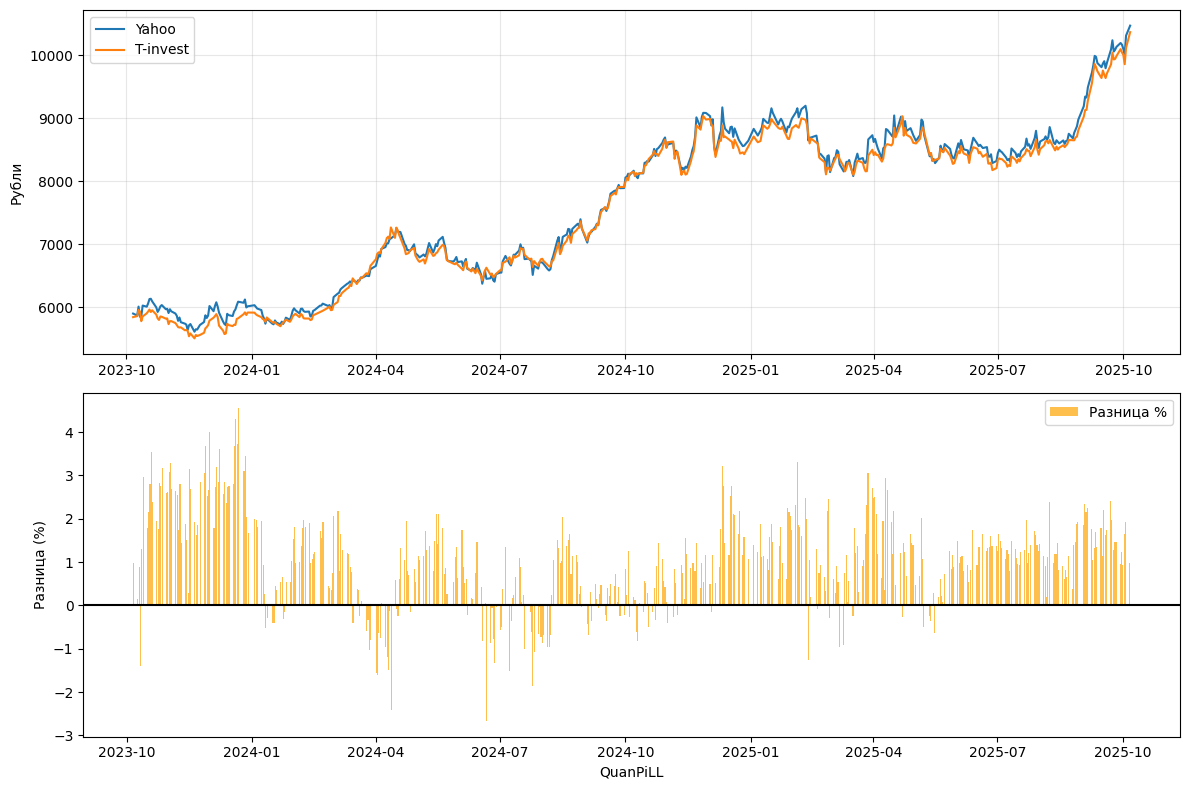

In [315]:
# show the plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Цены
ax1.plot(merged_df.index, merged_df['Yahoo_per_gram'], label='Yahoo')
ax1.plot(merged_df.index, merged_df['T_per_gram'], label='T-invest')
ax1.set_ylabel('Рубли')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Разница
ax2.bar(merged_df.index, merged_df['diff_percent'], alpha=0.7, color='orange', label='Разница %')
ax2.axhline(y=0, color='black')
ax2.set_ylabel('Разница (%)')
ax2.set_xlabel('QuanPiLL')
ax2.legend()

plt.tight_layout()
plt.show()